<h2 align="center">Elumina : Crash detection tangent</h2>


In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

if device.type == "mps":
    print("Using Metal backend on macOS (MPS)")
elif device.type == "cuda":
    print("Using CUDA (GPU)")
else:
    print("Using CPU")

device

Using Metal backend on macOS (MPS)


device(type='mps')

### Load Data


In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2302

In [5]:
2300*0.75

1725.0

In [6]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [7]:
num_classes = len(dataset.classes)
num_classes

6

In [8]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1726, 576)

In [9]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [11]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
labels[1]

tensor(2)

In [13]:
images[1].shape

torch.Size([3, 224, 224])

In [14]:
images[1].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


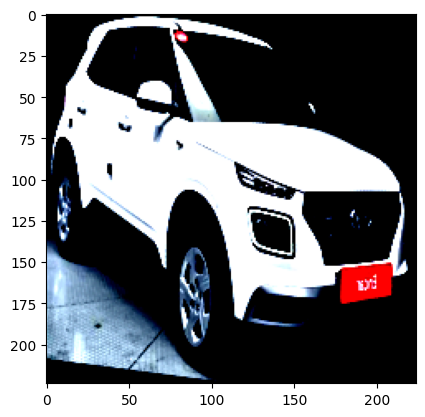

In [15]:
plt.imshow(images[1].permute(1, 2, 0))
plt.show()

### CNN


In [16]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                      stride=1, padding=1),  # (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,
                         padding=0),  # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [17]:
images.size(0)

32

In [18]:
len(train_loader.dataset)

1726

In [19]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(
                    f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")

    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return all_labels, all_predictions

In [20]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(
    model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.81
Batch: 20, Epoch: 1, Loss: 1.71
Batch: 30, Epoch: 1, Loss: 1.59
Batch: 40, Epoch: 1, Loss: 1.57
Batch: 50, Epoch: 1, Loss: 1.16
Epoch [1/10], Avg Loss: 1.7408
*** Validation Accuracy: 45.14% ***
Batch: 10, Epoch: 2, Loss: 1.39
Batch: 20, Epoch: 2, Loss: 1.00
Batch: 30, Epoch: 2, Loss: 1.18
Batch: 40, Epoch: 2, Loss: 1.22
Batch: 50, Epoch: 2, Loss: 1.33
Epoch [2/10], Avg Loss: 1.1718
*** Validation Accuracy: 51.04% ***
Batch: 10, Epoch: 3, Loss: 1.00
Batch: 20, Epoch: 3, Loss: 1.04
Batch: 30, Epoch: 3, Loss: 0.82
Batch: 40, Epoch: 3, Loss: 0.82
Batch: 50, Epoch: 3, Loss: 0.98
Epoch [3/10], Avg Loss: 0.9917
*** Validation Accuracy: 55.90% ***
Batch: 10, Epoch: 4, Loss: 0.82
Batch: 20, Epoch: 4, Loss: 0.77
Batch: 30, Epoch: 4, Loss: 1.04
Batch: 40, Epoch: 4, Loss: 0.88
Batch: 50, Epoch: 4, Loss: 1.02
Epoch [4/10], Avg Loss: 0.9040
*** Validation Accuracy: 54.69% ***
Batch: 10, Epoch: 5, Loss: 0.78
Batch: 20, Epoch: 5, Loss: 0.97
Batch: 30, Epoch: 5, Loss: 0

### Adding Regularization


In [21]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                      stride=1, padding=1),  # (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,
                         padding=0),  # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [22]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(
    model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 18.45
Batch: 20, Epoch: 1, Loss: 3.67
Batch: 30, Epoch: 1, Loss: 2.28
Batch: 40, Epoch: 1, Loss: 1.55
Batch: 50, Epoch: 1, Loss: 1.57
Epoch [1/10], Avg Loss: 6.9118
*** Validation Accuracy: 43.58% ***
Batch: 10, Epoch: 2, Loss: 1.62
Batch: 20, Epoch: 2, Loss: 1.27
Batch: 30, Epoch: 2, Loss: 1.40
Batch: 40, Epoch: 2, Loss: 1.34
Batch: 50, Epoch: 2, Loss: 1.42
Epoch [2/10], Avg Loss: 1.3842
*** Validation Accuracy: 47.40% ***
Batch: 10, Epoch: 3, Loss: 1.42
Batch: 20, Epoch: 3, Loss: 1.52
Batch: 30, Epoch: 3, Loss: 0.90
Batch: 40, Epoch: 3, Loss: 1.05
Batch: 50, Epoch: 3, Loss: 1.24
Epoch [3/10], Avg Loss: 1.2498
*** Validation Accuracy: 51.56% ***
Batch: 10, Epoch: 4, Loss: 1.41
Batch: 20, Epoch: 4, Loss: 1.08
Batch: 30, Epoch: 4, Loss: 1.26
Batch: 40, Epoch: 4, Loss: 0.99
Batch: 50, Epoch: 4, Loss: 1.19
Epoch [4/10], Avg Loss: 1.1843
*** Validation Accuracy: 54.86% ***
Batch: 10, Epoch: 5, Loss: 1.14
Batch: 20, Epoch: 5, Loss: 1.17
Batch: 30, Epoch: 5, Loss: 

### Transfer Learning with EfficientNet


In [23]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [24]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [25]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                       model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(
    model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.65
Batch: 20, Epoch: 1, Loss: 1.64
Batch: 30, Epoch: 1, Loss: 1.36
Batch: 40, Epoch: 1, Loss: 1.31
Batch: 50, Epoch: 1, Loss: 1.18
Epoch [1/10], Avg Loss: 1.4573
*** Validation Accuracy: 60.42% ***
Batch: 10, Epoch: 2, Loss: 1.08
Batch: 20, Epoch: 2, Loss: 1.14
Batch: 30, Epoch: 2, Loss: 1.03
Batch: 40, Epoch: 2, Loss: 1.09
Batch: 50, Epoch: 2, Loss: 1.01
Epoch [2/10], Avg Loss: 1.1258
*** Validation Accuracy: 62.15% ***
Batch: 10, Epoch: 3, Loss: 1.22
Batch: 20, Epoch: 3, Loss: 0.90
Batch: 30, Epoch: 3, Loss: 0.78
Batch: 40, Epoch: 3, Loss: 1.26
Batch: 50, Epoch: 3, Loss: 0.96
Epoch [3/10], Avg Loss: 1.0181
*** Validation Accuracy: 63.89% ***
Batch: 10, Epoch: 4, Loss: 0.98
Batch: 20, Epoch: 4, Loss: 0.76
Batch: 30, Epoch: 4, Loss: 0.89
Batch: 40, Epoch: 4, Loss: 0.86
Batch: 50, Epoch: 4, Loss: 0.96
Epoch [4/10], Avg Loss: 0.9508
*** Validation Accuracy: 67.71% ***
Batch: 10, Epoch: 5, Loss: 0.85
Batch: 20, Epoch: 5, Loss: 0.84
Batch: 30, Epoch: 5, Loss: 0

### Transfer Learning with ResNet


In [26]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [27]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                       model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.17
Batch: 20, Epoch: 1, Loss: 0.95
Batch: 30, Epoch: 1, Loss: 0.57
Batch: 40, Epoch: 1, Loss: 0.57
Batch: 50, Epoch: 1, Loss: 0.89
Epoch [1/10], Avg Loss: 0.8862
*** Validation Accuracy: 62.50% ***
Batch: 10, Epoch: 2, Loss: 0.59
Batch: 20, Epoch: 2, Loss: 0.42
Batch: 30, Epoch: 2, Loss: 0.58
Batch: 40, Epoch: 2, Loss: 0.39
Batch: 50, Epoch: 2, Loss: 0.51
Epoch [2/10], Avg Loss: 0.4503
*** Validation Accuracy: 77.43% ***
Batch: 10, Epoch: 3, Loss: 0.27
Batch: 20, Epoch: 3, Loss: 0.46
Batch: 30, Epoch: 3, Loss: 0.26
Batch: 40, Epoch: 3, Loss: 0.15
Batch: 50, Epoch: 3, Loss: 0.24
Epoch [3/10], Avg Loss: 0.3523
*** Validation Accuracy: 78.47% ***
Batch: 10, Epoch: 4, Loss: 0.22
Batch: 20, Epoch: 4, Loss: 0.14
Batch: 30, Epoch: 4, Loss: 0.25
Batch: 40, Epoch: 4, Loss: 0.20
Batch: 50, Epoch: 4, Loss: 0.48
Epoch [4/10], Avg Loss: 0.2770
*** Validation Accuracy: 81.08% ***
Batch: 10, Epoch: 5, Loss: 0.09
Batch: 20, Epoch: 5, Loss: 0.23
Batch: 30, Epoch: 5, Loss: 0

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005


In [28]:
model = CarClassifierResNet(num_classes=num_classes,
                            dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                       model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.17
Batch: 20, Epoch: 1, Loss: 0.78
Batch: 30, Epoch: 1, Loss: 0.92
Batch: 40, Epoch: 1, Loss: 0.55
Batch: 50, Epoch: 1, Loss: 0.73
Epoch [1/10], Avg Loss: 0.9699
*** Validation Accuracy: 58.33% ***
Batch: 10, Epoch: 2, Loss: 0.43
Batch: 20, Epoch: 2, Loss: 0.46
Batch: 30, Epoch: 2, Loss: 0.51
Batch: 40, Epoch: 2, Loss: 0.38
Batch: 50, Epoch: 2, Loss: 0.71
Epoch [2/10], Avg Loss: 0.4842
*** Validation Accuracy: 75.69% ***
Batch: 10, Epoch: 3, Loss: 0.39
Batch: 20, Epoch: 3, Loss: 0.28
Batch: 30, Epoch: 3, Loss: 0.46
Batch: 40, Epoch: 3, Loss: 0.72
Batch: 50, Epoch: 3, Loss: 0.38
Epoch [3/10], Avg Loss: 0.3806
*** Validation Accuracy: 78.47% ***
Batch: 10, Epoch: 4, Loss: 0.23
Batch: 20, Epoch: 4, Loss: 0.20
Batch: 30, Epoch: 4, Loss: 0.11
Batch: 40, Epoch: 4, Loss: 0.22
Batch: 50, Epoch: 4, Loss: 0.23
Epoch [4/10], Avg Loss: 0.2335
*** Validation Accuracy: 80.73% ***
Batch: 10, Epoch: 5, Loss: 0.11
Batch: 20, Epoch: 5, Loss: 0.12
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluation using Confusion Matrix and Classification Report


In [29]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       125
           1       0.85      0.67      0.75        96
           2       0.80      0.96      0.88       131
           3       0.70      0.87      0.77        67
           4       0.76      0.65      0.70        80
           5       0.78      0.74      0.76        77

    accuracy                           0.81       576
   macro avg       0.80      0.79      0.79       576
weighted avg       0.81      0.81      0.81       576



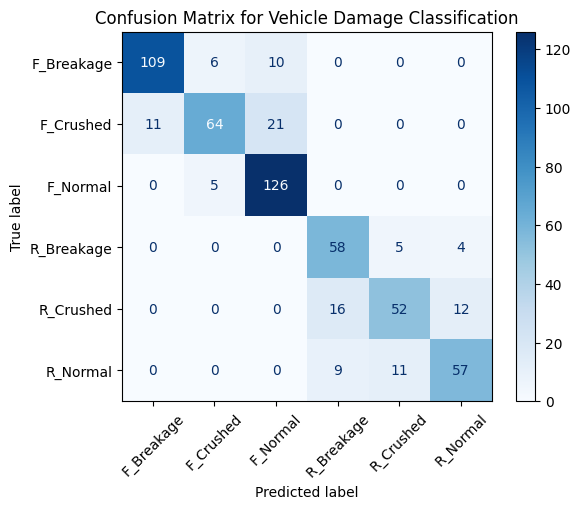

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(
    labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [31]:
torch.save(model.state_dict(), 'saved_model.pth')

In [32]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [33]:
from sklearn.metrics import classification_report

print("=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=class_names))


=== Classification Report ===
              precision    recall  f1-score   support

  F_Breakage       0.92      0.86      0.89       125
   F_Crushed       0.86      0.71      0.78        96
    F_Normal       0.80      0.96      0.88       131
  R_Breakage       0.75      0.88      0.81        67
   R_Crushed       0.78      0.65      0.71        80
    R_Normal       0.78      0.79      0.79        77

    accuracy                           0.82       576
   macro avg       0.82      0.81      0.81       576
weighted avg       0.83      0.82      0.82       576



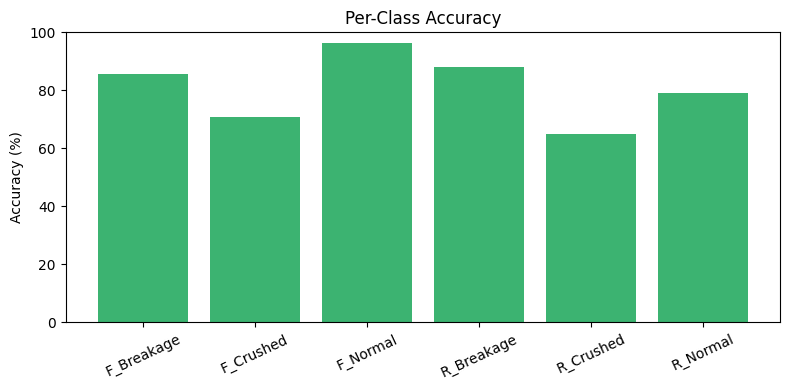

In [34]:
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(8,4))
plt.bar(class_names, class_accuracy*100, color='mediumseagreen')
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy")
plt.ylim(0, 100)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


In [35]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


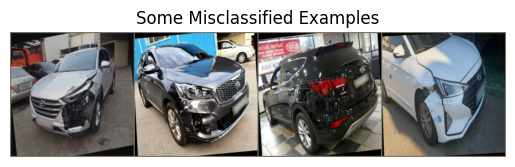

In [36]:

import random

from torchvision.utils import make_grid

misclassified_idx = [i for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p != t]

if len(misclassified_idx) > 0:
    idx_to_show = random.sample(misclassified_idx, min(4, len(misclassified_idx)))
    images_to_show = []
    for idx in idx_to_show:
        # Get image from validation dataset
        img, label = val_dataset[idx]
        images_to_show.append(img)
    grid = make_grid(images_to_show, nrow=4)
    imshow(grid, title="Some Misclassified Examples")
else:
    print("No misclassifications found!")


# Grad-CAM for ResNet Utility

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

def grad_cam_resnet(model, image_tensor, class_idx=None):
    """
    Grad-CAM for ResNet-type architectures.
    """
    model.eval()
    features = []
    gradients = []

    def save_feature_hook(module, input, output):
        features.append(output)

    def save_gradient_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # LAST conv layer for standard torchvision resnet is usually layer4[-1].conv2
    last_conv = model.layer4[-1].conv2 if hasattr(model.layer4[-1], 'conv2') else model.layer4[-1]
    h_feature = last_conv.register_forward_hook(save_feature_hook)
    h_gradient = last_conv.register_backward_hook(save_gradient_hook)

    output = model(image_tensor.unsqueeze(0).to(next(model.parameters()).device))
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()
    loss = output[0, class_idx]
    model.zero_grad()
    loss.backward()

    grads_val = gradients[0].cpu().data.numpy()[0]
    fmap = features[0].cpu().data.numpy()[0]
    weights = np.mean(grads_val, axis=(1, 2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= np.min(cam)
    cam /= (np.max(cam) + 1e-8)

    h_feature.remove()
    h_gradient.remove()
    return cam


In [38]:
def grad_cam_resnet_wrapped(model, image_tensor, class_idx=None):
    """
    Grad-CAM for a custom wrapper with model.model as a ResNet.
    """
    model.eval()
    features = []
    gradients = []

    # Hook into last Bottleneck's conv3
    last_conv = model.model.layer4[-1].conv3

    def save_feature_hook(module, input, output):
        features.append(output)

    def save_gradient_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    h_feature = last_conv.register_forward_hook(save_feature_hook)
    h_gradient = last_conv.register_backward_hook(save_gradient_hook)

    output = model(image_tensor.unsqueeze(0).to(next(model.parameters()).device))
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()
    loss = output[0, class_idx]
    model.zero_grad()
    loss.backward()

    grads_val = gradients[0].cpu().data.numpy()[0]
    fmap = features[0].cpu().data.numpy()[0]
    weights = np.mean(grads_val, axis=(1, 2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= np.min(cam)
    cam /= (np.max(cam) + 1e-8)

    h_feature.remove()
    h_gradient.remove()
    return cam


# Grad-CAM + Bounding Box Visualization

# Structured prediction report function

In [39]:
import torchvision.transforms as transforms

def predict_with_report(model, img_path, class_names, threshold=0.6):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).to(next(model.parameters()).device)
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0))
        probs = torch.softmax(output, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
        pred_class = class_names[pred_idx]
        pred_conf = probs[pred_idx].item()
        severity = round(pred_conf * 100, 2)
        manual_review = pred_conf < threshold
        report = {
            'Predicted Class': pred_class,
            'Confidence (%)': round(pred_conf * 100, 2),
            'Severity (%)': severity,
            'Manual Review Needed': manual_review
        }
    print("=== Damage Detection Report ===")
    for k, v in report.items():
        print(f"{k}: {v}")
    return img_tensor, pred_idx, report


In [40]:
print(model)

CarClassifierResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    def forward(self, x):
        return self.model(x)

num_classes = 6
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.5).to(device)
checkpoint = torch.load('saved_model.pth', map_location=device)
model.load_state_dict(checkpoint)
model.eval()

test_image_path = 'dataset/car1.jpg'  # adjust if needed
img = Image.open(test_image_path)
x = data_transforms(img).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(x)
probs = F.softmax(outputs, dim=1).cpu().numpy()[0]

classes = [
    'F_Breakage',
    'F_Crushed',
    'F_Normal',
    'R_Breakage',
    'R_Crushed',
    'R_Normal'
]

print("\nPredicted damage probabilities (as percentages):\n")
for idx, cls in enumerate(classes):
    print(f"{cls}: {probs[idx] * 100:.2f}%")

pred_idx = probs.argmax()
print(f"\nPrediction: {classes[pred_idx]} ({probs[pred_idx] * 100:.2f}% confidence)")



Predicted damage probabilities (as percentages):

F_Breakage: 0.00%
F_Crushed: 0.00%
F_Normal: 0.23%
R_Breakage: 1.49%
R_Crushed: 1.05%
R_Normal: 97.22%

Prediction: R_Normal (97.22% confidence)


Using device: cpu
Classes: ['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']
Confidence report:
  F_Breakage: 0.0%
  F_Crushed: 0.0%
  F_Normal: 0.2%
  R_Breakage: 0.0%
  R_Crushed: 0.0%
  R_Normal: 99.8%


/Users/rugved/Developer/untitled folder/elumina/myenv/lib/python3.9/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


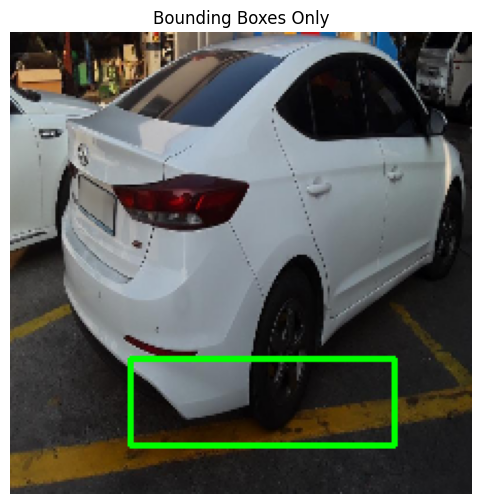

In [48]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt

# 1. Simulate argparse for notebook
import types
args = types.SimpleNamespace()
args.image = "car1.jpg"                 # Change this to your test image path
args.checkpoint = "saved_model.pth"     # Path to your saved model
args.threshold = 0.5                    # CAM heatmap threshold for bounding box

# 2. Device and transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

IMG_SIZE = 224
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 3. Load dataset class names
dataset = datasets.ImageFolder("dataset", transform=preprocess)
class_names = dataset.classes
print("Classes:", class_names)

# 4. Build base ResNet model
base = models.resnet50(pretrained=False)
in_features = base.fc.in_features

# 5. Load checkpoint and extract state dict
checkpoint = torch.load(args.checkpoint, map_location=device)
if isinstance(checkpoint, dict):
    if "model_state_dict" in checkpoint:
        sd = checkpoint["model_state_dict"]
    elif "state_dict" in checkpoint:
        sd = checkpoint["state_dict"]
    else:
        sd = checkpoint
else:
    sd = checkpoint

# Strip "model." prefix from state keys
clean_sd = {}
for k, v in sd.items():
    new_k = k[len("model."):] if k.startswith("model.") else k
    clean_sd[new_k] = v

# 6. Handle final FC layer naming
if "fc.1.weight" in clean_sd:
    num_classes = clean_sd["fc.1.weight"].shape[0]
    base.fc = nn.Linear(in_features, num_classes)
    clean_sd["fc.weight"] = clean_sd.pop("fc.1.weight")
    clean_sd["fc.bias"]   = clean_sd.pop("fc.1.bias")
else:
    num_classes = clean_sd["fc.weight"].shape[0]
    base.fc = nn.Linear(in_features, num_classes)

# 7. Load weights into model
base.load_state_dict(clean_sd)
model = base.to(device)
model.eval()

# 8. Prediction function
def predict_with_report(model, img_path, class_names):
    img_bgr = cv2.imread(img_path)
    img_rgb = img_bgr[:, :, ::-1]
    img_pil = Image.fromarray(img_rgb)
    inp     = preprocess(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(inp)
        probs  = F.softmax(logits, dim=1)[0].cpu().numpy()
    pred_idx = int(probs.argmax())
    print("Confidence report:")
    for i, cls in enumerate(class_names):
        print(f"  {cls}: {probs[i]*100:.1f}%")
    return inp, pred_idx

# 9. Grad‑CAM extraction
def grad_cam_resnet(model, input_tensor, target_class):
    conv_layer = model.layer4[-1].conv2
    feats, grads = [], []
    handle_fw = conv_layer.register_forward_hook(lambda m, i, o: feats.append(o))
    handle_bw = conv_layer.register_backward_hook(lambda m, gi, go: grads.append(go[0]))
    model.zero_grad()
    out = model(input_tensor)
    out[0, target_class].backward()
    feat = feats[0][0].cpu().data.numpy()
    grad = grads[0][0].cpu().data.numpy()
    handle_fw.remove()
    handle_bw.remove()
    weights = grad.mean(axis=(1,2))
    cam = np.zeros(feat.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * feat[i]
    cam = np.maximum(cam, 0)
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)
    return cv2.resize(cam, (IMG_SIZE, IMG_SIZE))

# 10. Bounding‑box only visualization
def show_bounding_box_only(img_path, cam, threshold=0.5):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask = (cam > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.figure(figsize=(6,6))
    plt.imshow(img[:, :, ::-1])
    plt.axis("off")
    plt.title("Bounding Boxes Only")
    plt.show()

# 11. Run
inp, pred_idx = predict_with_report(model, args.image, class_names)
cam_map       = grad_cam_resnet(model, inp, pred_idx)
show_bounding_box_only(args.image, cam_map, threshold=args.threshold)


In [43]:

import cv2
from IPython.display import Video, display
import tempfile

def process_video(video_path, model, transform, label_map):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_path = tempfile.NamedTemporaryFile(suffix='.mp4', delete=False).name
    out = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize and convert for model input
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img).resize((224, 224))
        input_tensor = transform(pil_img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()
            label = label_map.get(pred, "Unknown")

        # Draw bounding box and label
        h, w, _ = frame.shape
        cv2.rectangle(frame, (20, 20), (w-20, h-20), (0, 0, 255), 3)
        cv2.putText(frame, label, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)

        # Write output
        if out is None:
            out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (frame.shape[1], frame.shape[0]))
        out.write(frame)

    cap.release()
    out.release()
    return out_path

# Example usage
label_map = {0: "Normal", 1: "Accident", 2: "fire"}
video_path = "sample_video.mp4"  # Replace with uploaded path
processed_path = process_video(video_path, model, transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]), label_map)

display(Video(filename=processed_path, embed=True))


OpenCV: Couldn't read video stream from file "sample_video.mp4"


AttributeError: 'NoneType' object has no attribute 'release'